In [1]:
# Covid19 Analysis


In [2]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import r2_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from haversine import haversine, Unit
from haversine import haversine_vector
from mlxtend.evaluate import bootstrap


In [3]:
# reading dataset
# https://opendatasus.saude.gov.br/dataset/bd-srag-2020

df = pd.read_csv('/home/pedro/bkp/code/dataset/INFLUD-21-09-2020.csv',sep=';',encoding = "ISO-8859-1")

# Inputing constraint in the dataset 

# Positive case:

df = df[df['PCR_SARS2']==1]
print(df.shape)


# Hospitalized people:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110]
print(df.shape)

# Hospitalized people with age small than 110:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 3][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]
print(df.shape)


/home/pedro/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15,60,62,63,64,92,94,108,117,121,123) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(299142, 154)


<ipython-input-3-f1ed0beb5eec>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110]


(279982, 154)


<ipython-input-3-f1ed0beb5eec>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 3][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]


(242679, 154)


In [4]:
# Latitudes and longitudes table from municipalities

df_cod = pd.read_csv('/home/pedro/bkp/code/dataset/municipios.csv', sep=',')


In [5]:
# Removing last number from "codenumber"

df_cod['CO_MUN_RES'] = df_cod['CO_MUN_RES'].astype(str).str[:-1].astype(np.int64)
df_cod['CO_MU_INTE'] = df_cod['CO_MU_INTE'].astype(str).str[:-1].astype(np.int64)

In [6]:
# To match catalogues using muninipacity code
# latitude and longitude for pacient residence


result_01 = pd.merge(df, df_cod[['CO_MUN_RES','latitude_res','longitude_res']], on='CO_MUN_RES', how="left")
result_02 = pd.merge(df, df_cod[['CO_MU_INTE','latitude_int','longitude_int']], on='CO_MU_INTE', how="left") 

print(result_01.shape)
print(result_02.shape)

(242679, 156)
(242679, 156)


In [7]:
# To transforming in tuple

patient_mun_code  = result_01[['latitude_res','longitude_res']].to_numpy()
hospital_mun_code = result_02[['latitude_int','longitude_int']].to_numpy()


print(patient_mun_code.shape)
print(hospital_mun_code.shape)

(242679, 2)
(242679, 2)


In [8]:
# To calculate the distance from patient to hospital (difference between municipalities centers in km)

df['distance'] = haversine_vector(patient_mun_code, hospital_mun_code, Unit.KILOMETERS)

In [9]:
# To check

print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']])

        CO_MUN_RES  CO_MU_INTE     ID_MUNICIP    distance
7         351880.0    355030.0      SAO PAULO   13.951736
9         350570.0    355030.0      SAO PAULO   24.605443
10        355030.0    355030.0      SAO PAULO    0.000000
12        352670.0    352670.0           LEME    0.000000
18        355030.0    355030.0      SAO PAULO    0.000000
...            ...         ...            ...         ...
754858    330630.0    330630.0  VOLTA REDONDA    0.000000
754875    317020.0    317020.0     UBERLANDIA    0.000000
754892    291110.0    290320.0      BARREIRAS  125.383634
754896    230640.0    230440.0      FORTALEZA  118.057231
754897    330070.0    330070.0      CABO FRIO    0.000000

[242679 rows x 4 columns]


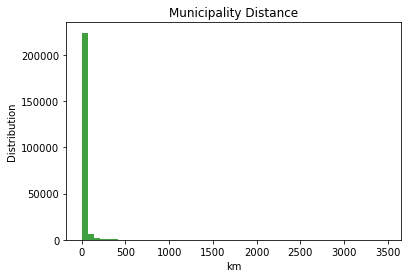

In [10]:
# Histogram for Municipality Distance

plt.hist(df['distance'], 50, density=False, facecolor='g', alpha=0.75) # .dropna(),
plt.xlabel('km')
plt.ylabel('Distribution')
plt.title('Municipality Distance')
plt.show()

In [11]:
# To check long distances

print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']][df['distance']>3000])

        CO_MUN_RES  CO_MU_INTE        ID_MUNICIP     distance
136401    431680.0    261160.0            RECIFE  3027.037343
200859    140010.0    420910.0         JOINVILLE  3479.593208
299138    421565.0    150405.0        MAE DO RIO  3019.144779
373144    110070.0    261160.0            RECIFE  3166.007414
509610    120020.0    310620.0    BELO HORIZONTE  3383.789594
573760    211120.0    430300.0  CACHOEIRA DO SUL  3195.009539
616802    260290.0    431440.0           PELOTAS  3165.723955
655586    160060.0    430910.0           GRAMADO  3261.277507
693063    431490.0    240800.0           MOSSORO  3121.907328
696975    140010.0    355030.0         SAO PAULO  3301.511571


In [12]:
print(df['distance'].max())
print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']][df['distance']>3479])                            

# Bigger distance  Boa Vista (Roraima) to Joinville (Santa Catarina)

3479.593208186318
        CO_MUN_RES  CO_MU_INTE ID_MUNICIP     distance
200859    140010.0    420910.0  JOINVILLE  3479.593208


In [13]:
# overcrowded dataset
# dataset with code from hospital (cnes) with epidemiology week and the overcrowded status of hospital.

df_cod = pd.read_csv('/home/pedro/bkp/code/dataset/hospital_overcrowded.csv', sep=',')

# CO_UNI_NOT, SEM_NOT, Overcrowded

# Overload = number of hospitalization in epidemiological week for COVID-19 / 2019 sum hospital hospitalization by SARS

In [14]:
# To check

df = pd.merge(df, df_cod, on=['CO_UNI_NOT', 'SEM_NOT'], how="left")
print(df.shape)

(242679, 156)


In [15]:
# Municipalities number inicial

# patient municipality code number
print(len(df['CO_MUN_NOT']))

# reporting health unit code number
print(len(df['CO_UNI_NOT']))


print(df['CO_MUN_NOT'].nunique())
print(df['CO_MUN_RES'].nunique())

242679
242679
1814
4401


In [16]:
# IDHM

# Reading IBGE code for each municipalities and separating it for IDHM index

df_atlas = pd.read_excel (r'/home/pedro/bkp/code/dataset/AtlasBrasil_Consulta.xlsx')


# removind last interger in 'code' variable

df_atlas['code'] = df_atlas['code'].astype(str).str[:-1].astype(np.int64)


# Divinding IDHM in bins

IDHM_veryhigh  =  set(df_atlas['code'][df_atlas['IDHM2010']>=0.800])
print(len(IDHM_veryhigh))


IDHM_high  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.700)&(df_atlas['IDHM2010']<0.800))])
print(len(IDHM_high))


IDHM_medium  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.600)&(df_atlas['IDHM2010']<0.700))])
print(len(IDHM_medium))


IDHM_low  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.500)&(df_atlas['IDHM2010']<0.600))])
print(len(IDHM_low))


IDHM_verylow  =  set(df_atlas['code'][df_atlas['IDHM2010']<0.500])
print(len(IDHM_verylow))




df.loc[df['CO_MUN_NOT'].isin(IDHM_veryhigh) == True, 'IDHM'] = 5
df.loc[df['CO_MUN_NOT'].isin(IDHM_high) == True, 'IDHM'] = 4
df.loc[df['CO_MUN_NOT'].isin(IDHM_medium) == True, 'IDHM'] = 3
df.loc[df['CO_MUN_NOT'].isin(IDHM_low) == True, 'IDHM'] = 2
df.loc[df['CO_MUN_NOT'].isin(IDHM_verylow) == True, 'IDHM'] = 1


44
1890
2233
1367
32


In [17]:
# Private and public hospital separation

df_hospital = pd.read_csv('/home/pedro/bkp/code/dataset/CNES_SUS.txt', sep='\t')


public   =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='S'])
private  =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='N'])


df.loc[df['CO_UNI_NOT'].isin(public) == True, 'HEALTH_SYSTEM'] = 1
df.loc[df['CO_UNI_NOT'].isin(private) == True, 'HEALTH_SYSTEM'] = 0

# CO_UNI_NOT

In [18]:
# Constraint on dataset: We only analyze people with evolution, IDHM and Health system outcomes

df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]
print(df.shape)

<ipython-input-18-8f4afe5f8a91>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]


(231112, 158)


In [19]:
# Municipalities number

print(len(df['CO_MUN_NOT']))
print(len(df['CO_MU_INTE']))

print(df['CO_MUN_NOT'].nunique())
print(df['CO_MU_INTE'].nunique())


231112
231112
1801
1766


In [20]:
# To selecting features and target

df = df[['Overload', 'distance','NU_IDADE_N','CS_SEXO','IDHM','CS_RACA','CS_ESCOL_N','SG_UF_NOT','CS_ZONA',\
'HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP','DISPNEIA','DIARREIA',\
'SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI','DIABETES',\
'OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]

In [21]:
# adding comorbidities

df['SUM_COMORBIDITIES'] = df.iloc[:,19:-1].replace([9,2], 0).fillna(0).sum(axis=1)
df['SUM_SYMPTOMS'] = df.iloc[:,11:17].replace([9,2], 0).fillna(0).sum(axis=1)


In [22]:
# Ordering features

df = df[['Overload', 'distance','NU_IDADE_N','CS_SEXO','IDHM','SUM_COMORBIDITIES','SUM_SYMPTOMS',\
'CS_RACA','CS_ESCOL_N','SG_UF_NOT','CS_ZONA','HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE',\
'GARGANTA','DESC_RESP','DISPNEIA','DIARREIA','SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI',\
'RENAL','HEMATOLOGI','DIABETES','OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]

In [23]:
# Pre-Processing

df = df[df['EVOLUCAO'].notnull()][df['EVOLUCAO']!=9][df['EVOLUCAO']!=3]#[df_BR['NU_IDADE_N'].notnull()]
df['CS_SEXO']=df['CS_SEXO'].replace({'M': 1, 'F':0, 'I':9, 'NaN':np.nan})


# replacing 2 by 0 (Death patients)
df.iloc[:,13:] = df.iloc[:,13:].replace(to_replace = 2.0, value =0) 


df['SG_UF_NOT'] = df['SG_UF_NOT'].map({'SP': 0, 'RJ':1, 'MG': 2 , 'ES':3, \
'RS':4, 'SC': 5, 'PR': 6, 'MT': 7, 'MS': 8, 'GO':9, 'DF':10, 'RO':11,'AC':12,'AM':13,\
'RR':14,'PA':15,'AP':16,'TO':17,'MA':18,'PI':19,'BA':20,'CE':21,'RN':22,'PB':23,'PE':24,'AL':25,'SE':26})

# For missing values in comorbidities and symptoms we filled by 0.
df.iloc[:,13:-1] = df.iloc[:,13:-1].fillna(0)

In [24]:
# feature
x = df.iloc[:,:-1]

# labels
y = df['EVOLUCAO']

In [25]:
# data separation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=5)


In [26]:
params = params = {'booster ':['gbtree'],
        'n_estimators': [200],          
        'eta':[0.2],    
        'max_depth':[4],
        'gamma': [1],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
            }


                            
                            
xgb = XGBClassifier()
gs = GridSearchCV(estimator=xgb, param_grid=params, return_train_score=True, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train, y_train)


print(gs.best_score_)
print(gs.best_params_)


print(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['std_test_score'])

print(gs.cv_results_['mean_train_score'])   
print(gs.cv_results_['std_train_score'])   



clf = gs.best_estimator_
clf.fit(x_train, y_train)


# save the model to disk
filename_nn = 'xgb_with_symptoms.sav'
pickle.dump(clf, open(filename_nn, 'wb')) 

/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:52] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:27:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:10] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:28:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:28] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:28:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:42] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:28:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:56] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:28:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:11] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:25] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:40] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:54] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:09] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pedro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:23] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8106485094585718
{'booster ': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.2, 'gamma': 1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
[0.81064851]
[0.00372628]
[0.82167286]
[0.00050638]
[18:30:39] WARNING: ../src/learner.cc:541: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some para

In [27]:
# load the model from disk
loaded_model_xgb = pickle.load(open('xgb_with_symptoms.sav', 'rb'))

In [28]:
# To predicting 
xgb_pred = loaded_model_xgb.predict_proba(x_test)

In [29]:
def auc_CI(df_test):
    x_test, y_test = df_test[:, :-1], df_test[:,[-1]]
    pred = loaded_model_xgb.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred[:,1], pos_label=1)
    return auc(x=fpr, y=tpr)


df_test = pd.merge(x_test, y_test, left_index=True, right_index=True)

In [30]:
# Febre
original, std_err, ci_bounds = bootstrap(df_test[df['FEBRE']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Febre: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Febre number of data %d' % df_test[df_test['FEBRE']==1].shape[0])


<ipython-input-30-a0f3877a6e83>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['FEBRE']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Febre: 0.813, SE: +/- 0.002, CI95: [0.808, 0.818]
Febre number of data 30650


In [31]:
# Vomito
original, std_err, ci_bounds = bootstrap(df_test[df['VOMITO']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Vomito: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Vomito number of data %d' % df_test[df_test['VOMITO']==1].shape[0])


<ipython-input-31-19b516a3fc4b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['VOMITO']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Vomito: 0.810, SE: +/- 0.008, CI95: [0.793, 0.826]
Vomito number of data 3653


In [32]:
# Vomito
original, std_err, ci_bounds = bootstrap(df_test[df['TOSSE']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean TOSSE: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('TOSSE number of data %d' % df_test[df_test['TOSSE']==1].shape[0])

<ipython-input-32-b211a7e740fa>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['TOSSE']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean TOSSE: 0.808, SE: +/- 0.002, CI95: [0.804, 0.813]
TOSSE number of data 33955


In [33]:
# GARGANTA
original, std_err, ci_bounds = bootstrap(df_test[df['GARGANTA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean GARGANTA: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('GARGANTA number of data %d' % df_test[df_test['GARGANTA']==1].shape[0])

<ipython-input-33-5009180c5edc>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['GARGANTA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean GARGANTA: 0.821, SE: +/- 0.005, CI95: [0.812, 0.831]
GARGANTA number of data 8268


In [34]:
# DESC_RESP
original, std_err, ci_bounds = bootstrap(df_test[df['DESC_RESP']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean DESC_RESP: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('DESC_RESP number of data %d' % df_test[df_test['DESC_RESP']==1].shape[0])

<ipython-input-34-85fd8e01b3c0>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['DESC_RESP']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean DESC_RESP: 0.803, SE: +/- 0.002, CI95: [0.798, 0.808]
DESC_RESP number of data 26473


In [35]:
# DISPNEIA
original, std_err, ci_bounds = bootstrap(df_test[df['DISPNEIA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean DISPNEIA: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('DISPNEIA number of data %d' % df_test[df_test['DISPNEIA']==1].shape[0])

<ipython-input-35-5db4c19b47c1>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['DISPNEIA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean DISPNEIA: 0.802, SE: +/- 0.002, CI95: [0.797, 0.806]
DISPNEIA number of data 33066


In [36]:
# DIARREIA
original, std_err, ci_bounds = bootstrap(df_test[df['DIARREIA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean DIARREIA: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('DIARREIA number of data %d' % df_test[df_test['DIARREIA']==1].shape[0])

<ipython-input-36-ad54d38c7973>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['DIARREIA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean DIARREIA: 0.811, SE: +/- 0.005, CI95: [0.799, 0.820]
DIARREIA number of data 6384


In [37]:
# SATURACAO
original, std_err, ci_bounds = bootstrap(df_test[df['SATURACAO']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean SATURACAO: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('SATURACAO number of data %d' % df_test[df_test['SATURACAO']==1].shape[0])

<ipython-input-37-5dab2f69cd03>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['SATURACAO']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean SATURACAO: 0.787, SE: +/- 0.003, CI95: [0.780, 0.795]
SATURACAO number of data 27239


In [38]:
# CARDIOPATI
original, std_err, ci_bounds = bootstrap(df_test[df['CARDIOPATI']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean CARDIOPATI: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('CARDIOPATI number of data %d' % df_test[df_test['CARDIOPATI']==1].shape[0])

<ipython-input-38-91ed7e705719>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CARDIOPATI']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean CARDIOPATI: 0.767, SE: +/- 0.003, CI95: [0.760, 0.774]
CARDIOPATI number of data 16294


In [39]:
# 'HEPATICA'
original, std_err, ci_bounds = bootstrap(df_test[df['HEPATICA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean HEPATICA: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('HEPATICA number of data %d' % df_test[df_test['HEPATICA']==1].shape[0])

<ipython-input-39-3b469b2269a9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['HEPATICA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean HEPATICA: 0.731, SE: +/- 0.022, CI95: [0.695, 0.773]
HEPATICA number of data 441


In [40]:
# ASMA
original, std_err, ci_bounds = bootstrap(df_test[df['ASMA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean ASMA: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('ASMA number of data %d' % df_test[df_test['ASMA']==1].shape[0])

<ipython-input-40-73327a425536>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['ASMA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean ASMA: 0.810, SE: +/- 0.014, CI95: [0.781, 0.837]
ASMA number of data 1227


In [41]:
# PNEUMOPATI
original, std_err, ci_bounds = bootstrap(df_test[df['PNEUMOPATI']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean PNEUMOPATI: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('PNEUMOPATI number of data %d' % df_test[df_test['PNEUMOPATI']==1].shape[0])

<ipython-input-41-d8fd4022cf52>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['PNEUMOPATI']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean PNEUMOPATI: 0.746, SE: +/- 0.012, CI95: [0.723, 0.772]
PNEUMOPATI number of data 1892


In [42]:
# RENAL
original, std_err, ci_bounds = bootstrap(df_test[df['RENAL']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean RENAL: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('RENAL number of data %d' % df_test[df_test['RENAL']==1].shape[0])

<ipython-input-42-eff2f222c2c4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['RENAL']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean RENAL: 0.719, SE: +/- 0.011, CI95: [0.699, 0.738]
RENAL number of data 2166


In [43]:
# HEMATOLOGI
original, std_err, ci_bounds = bootstrap(df_test[df['HEMATOLOGI']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean HEMATOLOGI: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('HEMATOLOGI number of data %d' % df_test[df_test['HEMATOLOGI']==1].shape[0])

<ipython-input-43-2df657784fdf>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['HEMATOLOGI']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean HEMATOLOGI: 0.804, SE: +/- 0.022, CI95: [0.767, 0.851]
HEMATOLOGI number of data 400


In [44]:
# DIABETES
original, std_err, ci_bounds = bootstrap(df_test[df['DIABETES']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean DIABETES: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('DIABETES number of data %d' % df_test[df_test['DIABETES']==1].shape[0])

<ipython-input-44-bcd3640e8418>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['DIABETES']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean DIABETES: 0.758, SE: +/- 0.004, CI95: [0.750, 0.766]
DIABETES number of data 12132


In [45]:
# OBESIDADE
original, std_err, ci_bounds = bootstrap(df_test[df['OBESIDADE']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean OBESIDADE: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('OBESIDADE number of data %d' % df_test[df_test['OBESIDADE']==1].shape[0])

<ipython-input-45-c737d837294f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['OBESIDADE']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean OBESIDADE: 0.771, SE: +/- 0.010, CI95: [0.754, 0.793]
OBESIDADE number of data 2323


In [46]:
# NEUROLOGIC
original, std_err, ci_bounds = bootstrap(df_test[df['NEUROLOGIC']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean NEUROLOGIC: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('NEUROLOGIC number of data %d' % df_test[df_test['NEUROLOGIC']==1].shape[0])

<ipython-input-46-84cd5641a612>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['NEUROLOGIC']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean NEUROLOGIC: 0.727, SE: +/- 0.013, CI95: [0.701, 0.753]
NEUROLOGIC number of data 1985


In [47]:
# IMUNODEPRE
original, std_err, ci_bounds = bootstrap(df_test[df['IMUNODEPRE']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean IMUNODEPRE: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('IMUNODEPRE number of data %d' % df_test[df_test['IMUNODEPRE']==1].shape[0])

<ipython-input-47-597b9f0dd42d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['IMUNODEPRE']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean IMUNODEPRE: 0.741, SE: +/- 0.013, CI95: [0.715, 0.766]
IMUNODEPRE number of data 1449


In [48]:
# Female 
original, std_err, ci_bounds = bootstrap(df_test[df['CS_SEXO']==0].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Female: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Female number of data %d' % df_test[df_test['CS_SEXO']==0].shape[0])


<ipython-input-48-9fac9442a2ce>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_SEXO']==0].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Female: 0.811, SE: +/- 0.003, CI95: [0.805, 0.816]
Female number of data 20081


In [49]:
# Male
original, std_err, ci_bounds = bootstrap(df_test[df['CS_SEXO']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Male: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Male number of data %d' % df_test[df_test['CS_SEXO']==1].shape[0])

<ipython-input-49-f29441c98979>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_SEXO']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Male: 0.815, SE: +/- 0.003, CI95: [0.810, 0.820]
Male number of data 26131


In [50]:
# Hospital unit reporting  


# public
original, std_err, ci_bounds = bootstrap(df_test[df['HEALTH_SYSTEM']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean public: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Private number of data %d' % df_test[df_test['HEALTH_SYSTEM']==1].shape[0])

# private
original, std_err, ci_bounds = bootstrap(df_test[df['HEALTH_SYSTEM']==0].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean private: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Private number of data %d' % df_test[df_test['HEALTH_SYSTEM']==0].shape[0])

<ipython-input-50-8a5d633a9202>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['HEALTH_SYSTEM']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean public: 0.799, SE: +/- 0.002, CI95: [0.795, 0.802]
Private number of data 36603


<ipython-input-50-8a5d633a9202>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['HEALTH_SYSTEM']==0].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean private: 0.843, SE: +/- 0.004, CI95: [0.832, 0.851]
Private number of data 9620


In [51]:
# Hospital unit reporting  


# Branco
original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Branco: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Branco number of data %d' % df_test[df_test['CS_RACA']==1].shape[0])

# Preto
original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==2].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Preto: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Preto number of data %d' % df_test[df_test['CS_RACA']==2].shape[0])

# Amarelo
original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==3].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Amarelo: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Amarelo number of data %d' % df_test[df_test['CS_RACA']==3].shape[0])

# Pardo
original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==4].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Pardo: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Pardo number of data %d' % df_test[df_test['CS_RACA']==4].shape[0])

# Indigena
original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==5].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Indigena: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Indigena number of data %d' % df_test[df_test['CS_RACA']==5].shape[0])

<ipython-input-51-61631919b502>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Branco: 0.813, SE: +/- 0.003, CI95: [0.806, 0.821]
Branco number of data 17186


<ipython-input-51-61631919b502>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==2].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Preto: 0.803, SE: +/- 0.009, CI95: [0.780, 0.816]
Preto number of data 2293


<ipython-input-51-61631919b502>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==3].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Amarelo: 0.789, SE: +/- 0.023, CI95: [0.742, 0.825]
Amarelo number of data 519


<ipython-input-51-61631919b502>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==4].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Pardo: 0.804, SE: +/- 0.004, CI95: [0.797, 0.812]
Pardo number of data 13556
Mean Indigena: 0.891, SE: +/- 0.034, CI95: [0.821, 0.948]
Indigena number of data 98


<ipython-input-51-61631919b502>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_RACA']==5].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


In [52]:
# Education


# Illiterate
original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==0].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Illiterate: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Illiterate number of data %d' % df_test[df_test['CS_ESCOL_N']==0].shape[0])


# Fundamental I
original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Fundamental I: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Fundamental I number of data %d' % df_test[df_test['CS_ESCOL_N']==1].shape[0])


# Fundamental II
original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==2].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Fundamental II: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Fundamental II number of data %d' % df_test[df_test['CS_ESCOL_N']==2].shape[0])


# Medium
original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==3].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Medium: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Medium number of data %d' % df_test[df_test['CS_ESCOL_N']==3].shape[0])


# University
original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==4].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean University: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('University number of data %d' % df_test[df_test['CS_ESCOL_N']==4].shape[0])

<ipython-input-52-74fa8d8aff6d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==0].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Illiterate: 0.762, SE: +/- 0.014, CI95: [0.733, 0.790]
Illiterate number of data 1042


<ipython-input-52-74fa8d8aff6d>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Fundamental I: 0.773, SE: +/- 0.007, CI95: [0.759, 0.785]
Fundamental I number of data 4315


<ipython-input-52-74fa8d8aff6d>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==2].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Fundamental II: 0.808, SE: +/- 0.008, CI95: [0.793, 0.824]
Fundamental II number of data 3090


<ipython-input-52-74fa8d8aff6d>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==3].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Medium: 0.828, SE: +/- 0.006, CI95: [0.817, 0.840]
Medium number of data 5157


<ipython-input-52-74fa8d8aff6d>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_ESCOL_N']==4].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean University: 0.874, SE: +/- 0.008, CI95: [0.860, 0.889]
University number of data 2523


In [53]:
# Area


# Urban
original, std_err, ci_bounds = bootstrap(df_test[df['CS_ZONA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Urban: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Urban number of data %d' % df_test[df_test['CS_ZONA']==1].shape[0])


# Rural
original, std_err, ci_bounds = bootstrap(df_test[df['CS_ZONA']==2].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Rural: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Rural number of data %d' % df_test[df_test['CS_ZONA']==2].shape[0])


# Peri-urban
original, std_err, ci_bounds = bootstrap(df_test[df['CS_ZONA']==3].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Peri-urban University: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Peri-urban number of data %d' % df_test[df_test['CS_ZONA']==3].shape[0])


<ipython-input-53-accccf482ca6>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_ZONA']==1].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Urban: 0.813, SE: +/- 0.002, CI95: [0.808, 0.818]
Urban number of data 39777


<ipython-input-53-accccf482ca6>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_ZONA']==2].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Rural: 0.798, SE: +/- 0.014, CI95: [0.769, 0.823]
Rural number of data 1217
Peri-urban University: 0.795, SE: +/- 0.036, CI95: [0.711, 0.859]
Peri-urban number of data 143


<ipython-input-53-accccf482ca6>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['CS_ZONA']==3].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


In [54]:
# IDHM

# Very High

original, std_err, ci_bounds = bootstrap(df_test[df['IDHM']==5].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Very High: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Very High number of data %d' % df_test[df_test['IDHM']==5].shape[0])


# High

original, std_err, ci_bounds = bootstrap(df_test[df['IDHM']==4].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean High: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('High number of data %d' % df_test[df_test['IDHM']==4].shape[0])


# Medium Low

original, std_err, ci_bounds = bootstrap(df_test[((df['IDHM']==3)|(df['IDHM']==2)|(df['IDHM']==1))].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Medium Low: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Medium Low number of data %d' % df_test[((df['IDHM']==3)|(df['IDHM']==2)|(df['IDHM']==1))].shape[0])



<ipython-input-54-7a49df43d245>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['IDHM']==5].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Very High: 0.816, SE: +/- 0.003, CI95: [0.810, 0.823]
Very High number of data 18113


<ipython-input-54-7a49df43d245>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['IDHM']==4].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean High: 0.802, SE: +/- 0.003, CI95: [0.797, 0.808]
High number of data 24989


<ipython-input-54-7a49df43d245>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[((df['IDHM']==3)|(df['IDHM']==2)|(df['IDHM']==1))].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Medium Low: 0.791, SE: +/- 0.008, CI95: [0.776, 0.809]
Medium Low number of data 3121


<ipython-input-54-7a49df43d245>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Medium Low number of data %d' % df_test[((df['IDHM']==3)|(df['IDHM']==2)|(df['IDHM']==1))].shape[0])


In [55]:
# Macroregions


# Macro Regions

northeast  =  set([18,19,20,21,22,23,24,25,26])
north  =  set([11,12,13,14,15,16,17])
midwest  =  set([7,8,9,10])
southeast  =  set([0,1,2,3])
south = set([4,5,6])



# North

original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(north)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean North: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('North number of data %d' % df_test[df_test['SG_UF_NOT'].isin(north)].shape[0])


# Northeast

original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(northeast)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Northeast: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Northeast number of data %d' % df_test[df_test['SG_UF_NOT'].isin(northeast)].shape[0])


# Midwest

original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(midwest)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Midwest: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Midwest number of data %d' % df_test[df_test['SG_UF_NOT'].isin(midwest)].shape[0])


# Southeast

original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(southeast)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean Southeast: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('Southeast number of data %d' % df_test[df_test['SG_UF_NOT'].isin(southeast)].shape[0])


# South

original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(south)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)
print('Mean South: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))
print('South number of data %d' % df_test[df_test['SG_UF_NOT'].isin(south)].shape[0])


<ipython-input-55-3425c7845084>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(north)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean North: 0.781, SE: +/- 0.009, CI95: [0.765, 0.796]
North number of data 2413


<ipython-input-55-3425c7845084>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(northeast)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Northeast: 0.800, SE: +/- 0.005, CI95: [0.791, 0.807]
Northeast number of data 8455


<ipython-input-55-3425c7845084>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(midwest)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Midwest: 0.810, SE: +/- 0.008, CI95: [0.796, 0.824]
Midwest number of data 3663


<ipython-input-55-3425c7845084>:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(southeast)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean Southeast: 0.811, SE: +/- 0.003, CI95: [0.805, 0.816]
Southeast number of data 25951


<ipython-input-55-3425c7845084>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original, std_err, ci_bounds = bootstrap(df_test[df['SG_UF_NOT'].isin(south)].values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


Mean South: 0.809, SE: +/- 0.006, CI95: [0.800, 0.822]
South number of data 5741


In [56]:
# CI 95% calculation  AUC

def auc_CI(df_test):
    x_test, y_test = df_test[:, :-1], df_test[:,[-1]]
    xgb_pred = loaded_model_xgb.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, xgb_pred[:,1], pos_label=1)
    return auc(x=fpr, y=tpr)


df_test = pd.merge(x_test, y_test, left_index=True, right_index=True)
original, std_err, ci_bounds = bootstrap(df_test.values , num_rounds=100, func = auc_CI, ci=0.95, seed=123)


print('Mean: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))

Mean: 0.813, SE: +/- 0.002, CI95: [0.810, 0.817]


In [57]:
# CI 95% calculation  AP Death

def ap_CI_death(df_test):
    x_test, y_test = df_test[:, :-1], df_test[:,[-1]]
    xgb_pred = loaded_model_xgb.predict_proba(x_test)
    return average_precision_score(y_test, xgb_pred[:,0], pos_label=0)


df_test = pd.merge(x_test, y_test, left_index=True, right_index=True)
original, std_err, ci_bounds = bootstrap(df_test.values , num_rounds=100, func = ap_CI_death, ci=0.95, seed=123)


print('Mean Death: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))

Mean Death: 0.711, SE: +/- 0.004, CI95: [0.704, 0.721]


In [58]:
# CI 95% calculation  AP Cure

def ap_CI_cure(df_test):
    x_test, y_test = df_test[:, :-1], df_test[:,[-1]]
    xgb_pred = loaded_model_xgb.predict_proba(x_test)
    return average_precision_score(y_test, xgb_pred[:,1])


df_test = pd.merge(x_test, y_test, left_index=True, right_index=True)
original, std_err, ci_bounds = bootstrap(df_test.values , num_rounds=100, func = ap_CI_cure, ci=0.95, seed=123)


print('Mean Cure: %.3f, SE: +/- %.3f, CI95: [%.3f, %.3f]' % (original, std_err, ci_bounds[0], ci_bounds[1]))

Mean Cure: 0.879, SE: +/- 0.002, CI95: [0.876, 0.883]
